In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import re
import nltk
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, SimpleRNN
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline

In [2]:
# NLTK packages for text preprocessing
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\annjo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\annjo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Read the dataset
sentiment_df = pd.read_csv("Reviews.csv")
sentiment_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
def score_round(x):
    if x>=3:
        return 1
    else: 
        return 0

In [5]:
sentiment_df['review_score']= sentiment_df.Score.apply(score_round)

In [6]:
sentiment_df = sentiment_df.rename(columns={'Text':'review_text'})

In [7]:
import random

random.seed(a=40)  # Set the seed for random number generator
q = 0.8
# Use random.random() in the lambda function
review_val = pd.read_csv('Reviews.csv', skiprows=lambda i: i>0 and random.random() > q)
review_val.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
2,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
3,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
4,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...


In [8]:
review_val['review_score']=review_val.Score.apply(score_round)

In [9]:
review_val = review_val.rename(columns={'Text':'review_text'})

In [10]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   review_text             568454 non-null  object
 10  review_score            568454 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 47.7+ MB


In [11]:
sentiment_df.review_text = sentiment_df.review_text.astype('str')
review_val.review_text = sentiment_df.review_text.astype('str')

sentiment_df.Summary = sentiment_df.Summary.astype('str')
review_val.Summary = sentiment_df.Summary.astype('str')

In [12]:
temp = sentiment_df.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,review_score,review_text
1,1,486417
0,0,82037


<AxesSubplot:xlabel='review_score', ylabel='count'>

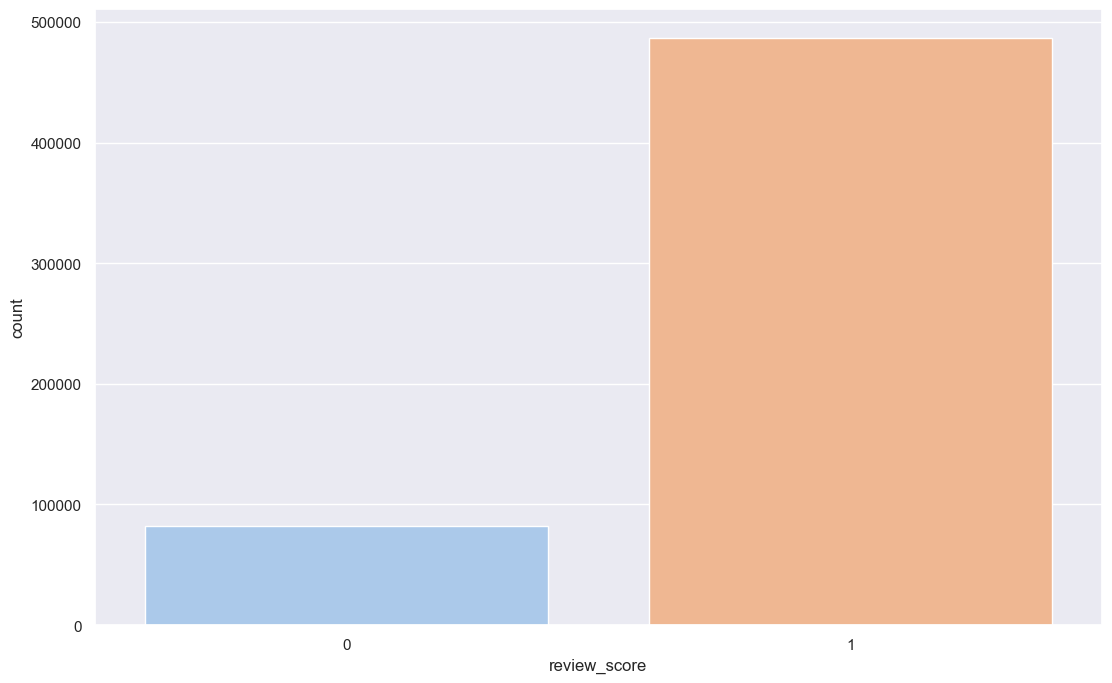

In [13]:
sns.set_theme(style='whitegrid')
sns.set(rc = {'figure.figsize':(13,8)})
sns.set_palette("pastel")
sns.countplot(x='review_score',data=sentiment_df)

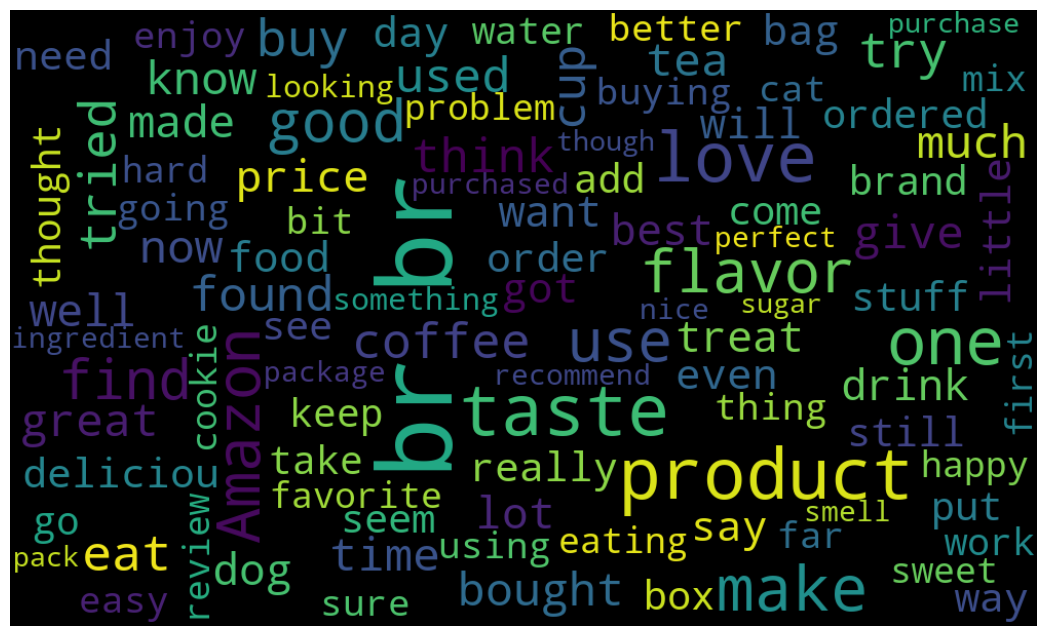

In [14]:
txt = ' '.join(rev for rev in sentiment_df.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [15]:
positive = sentiment_df[sentiment_df['review_score']==1]
negative = sentiment_df[sentiment_df['review_score']==0]

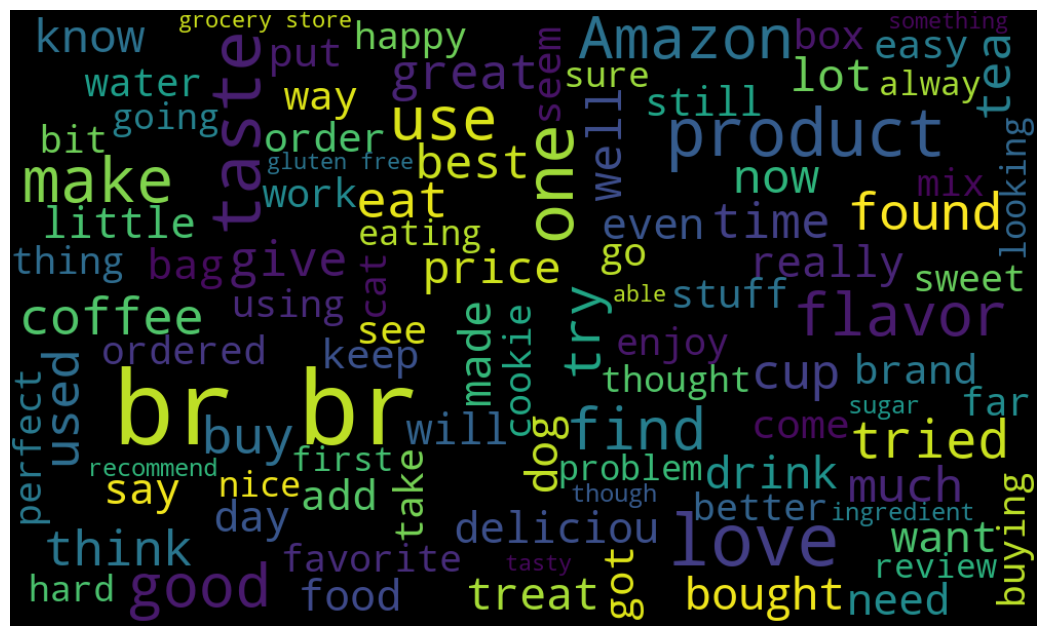

In [16]:
txt = ' '.join(rev for rev in positive.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

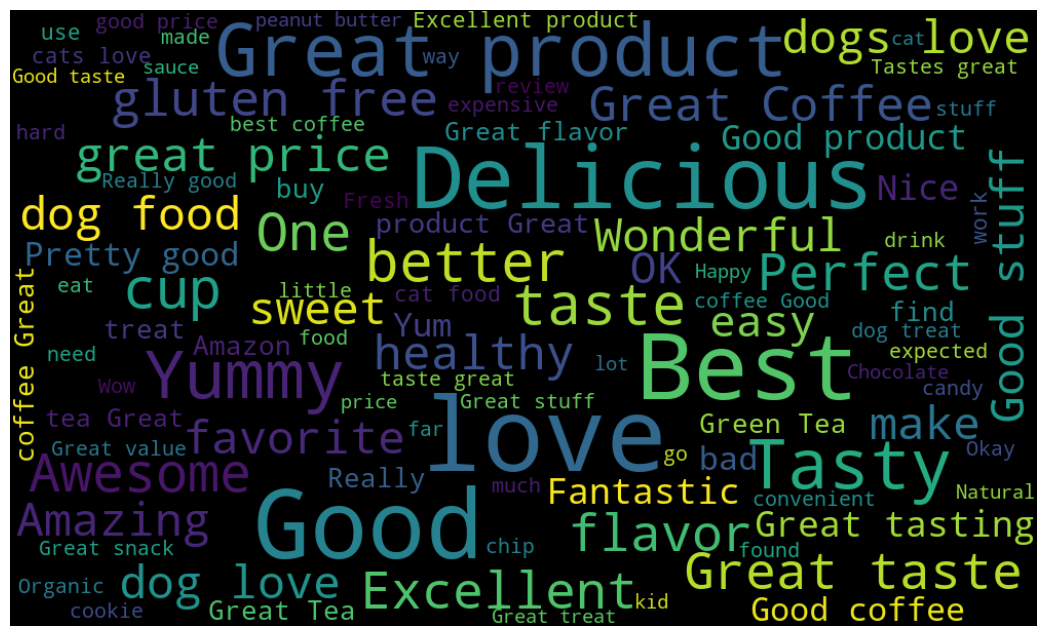

In [17]:
txt = ' '.join(rev for rev in positive.Summary)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

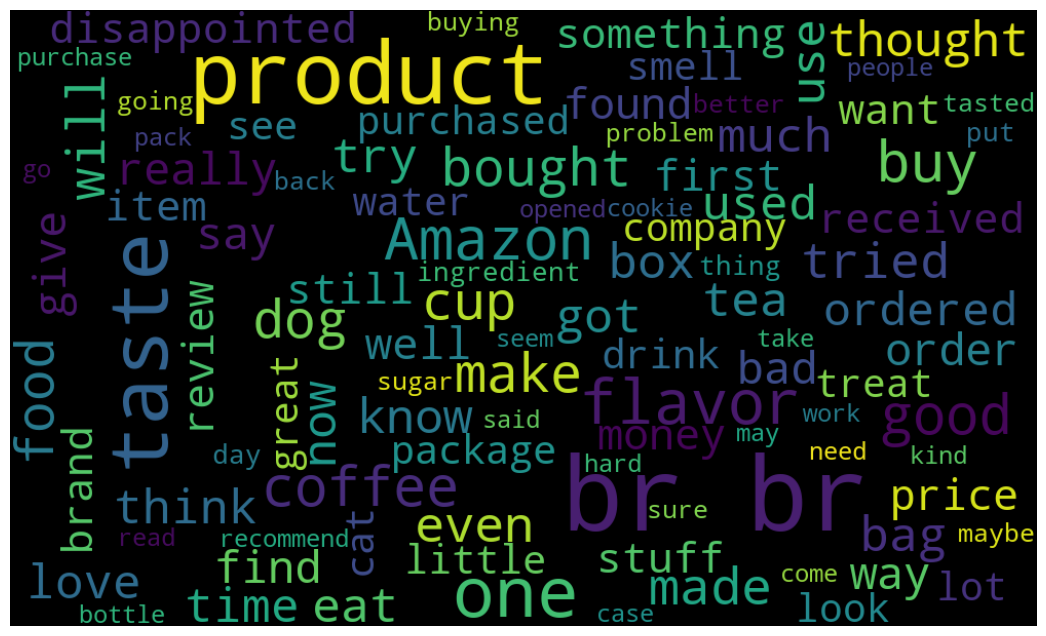

In [18]:
txt = ' '.join(rev for rev in negative.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

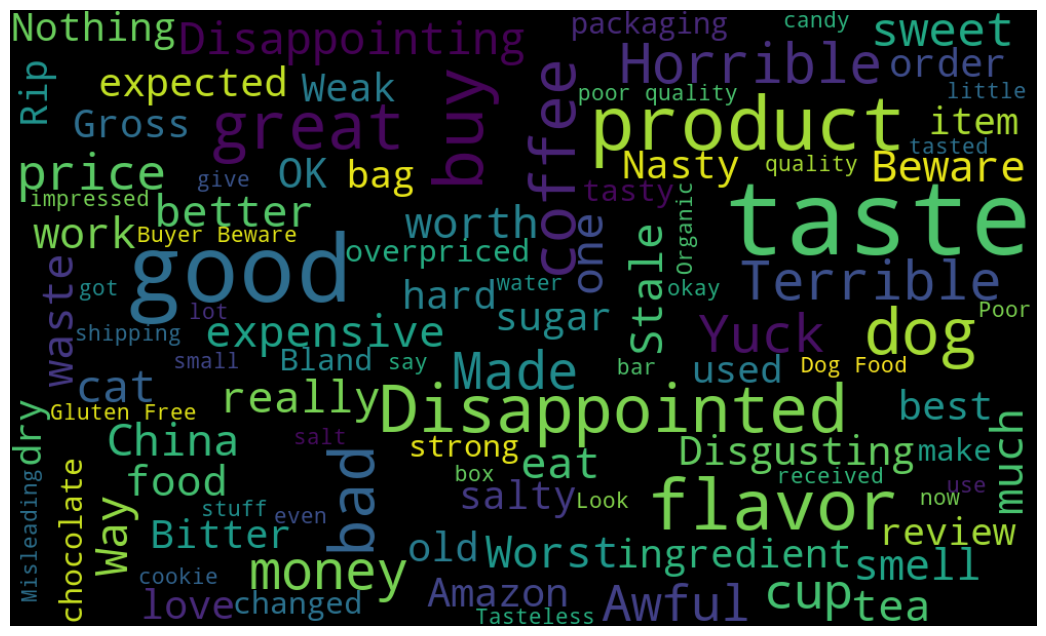

In [19]:
txt = ' '.join(rev for rev in negative.Summary)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [20]:
review_vis = sentiment_df.copy()

In [21]:
review_vis['Num_word_review'] = review_vis['review_text'].apply(lambda x:len(str(x).split()))

<AxesSubplot:xlabel='Num_word_review', ylabel='Count'>

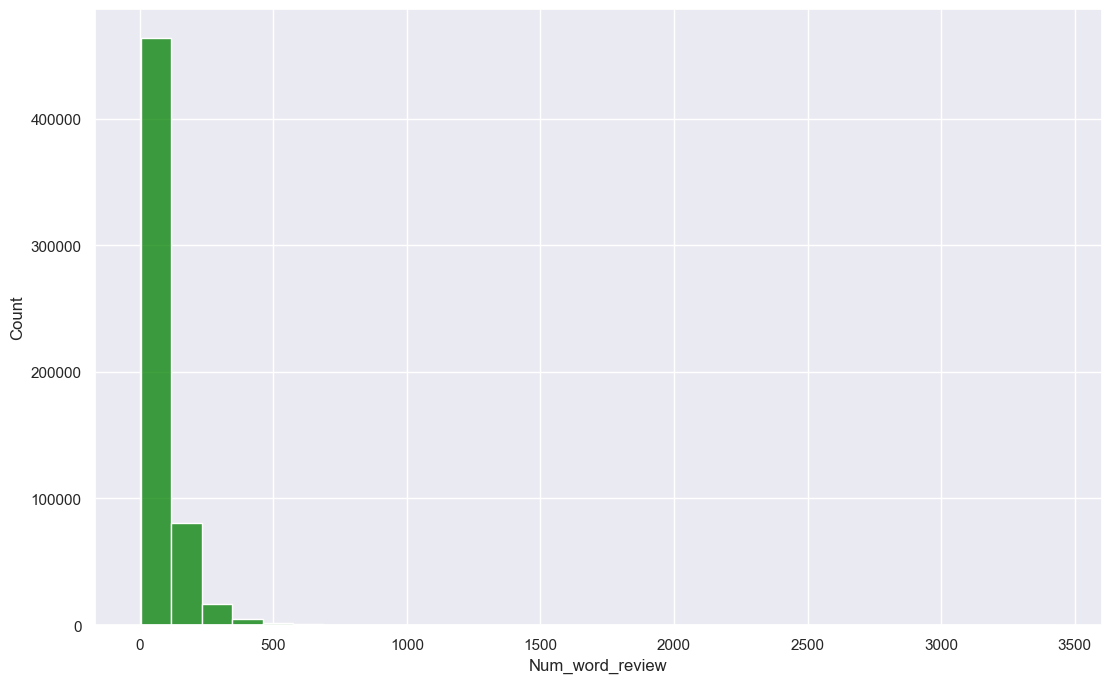

In [22]:
sns.histplot(data=review_vis, x="Num_word_review",bins=30,color='green')

In [23]:
from collections import Counter

# Your existing code
review_vis['temp_list'] = review_vis['review_text'].apply(lambda x: str(x).split())
top = Counter([item for sublist in review_vis['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,1628045
1,I,1388076
2,and,1228666
3,a,1163164
4,to,992367
5,of,789652
6,is,714264
7,it,631252
8,for,519983
9,in,512394


In [24]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\annjo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
sentiment_df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                    0
review_text                0
review_score               0
dtype: int64

In [26]:
sentiment_df = sentiment_df.drop_duplicates(keep='first')

In [27]:
sentiment_df.shape

(568454, 11)

In [28]:
# Preprocessing Functions
def clean(raw):
    # Remove hyperlinks, markup, and various HTML symbols
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

In [29]:
def remove_num(texts):
    # Remove numbers
    return re.sub(r'\d+', '', texts)

In [30]:
def deEmojify(x):
    # Remove emojis
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

In [31]:
def unify_whitespaces(x):
    # Unify multiple whitespaces into a single space
    return re.sub(' +', ' ', x)

In [32]:
def remove_symbols(x):
    # Remove special characters except basic punctuation
    return re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)

In [33]:
def remove_punctuation(text):
    # Remove punctuation
    return "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))

stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

In [34]:
def remove_stopword(text):
    # Remove stopwords
    return " ".join(word.lower() for word in text.split() if word.lower() not in stop)

In [35]:
def Stemming(text):
    # Apply stemming
    stem = []
    snowball_stemmer = SnowballStemmer('english')
    word_tokens = word_tokenize(text)
    stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
    return ' '.join(stemmed_word)

In [36]:
def cleaning(df, review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)
    df[review] = df[review].map(Stemming)

In [37]:
# Applying the cleaning function to the DataFrame with the correct column name
cleaning(sentiment_df, 'review_text')
cleaning(sentiment_df, 'Summary')  # Only if 'Summary' has not been renamed

# Display the first few rows of the DataFrame
sentiment_df[['review_text', 'Summary']].head()

,review_text,Summary
0,bought sever vital can dog food product found ...,good qualiti dog food
1,product arriv label jumbo salt peanutsth peanu...,advertis
2,confect around centuri light pillowi citrus ge...,delight say
3,look secret ingredi robitussin believ found go...,cough medicin
4,great taffi great price wide assort yummi taff...,great taffi


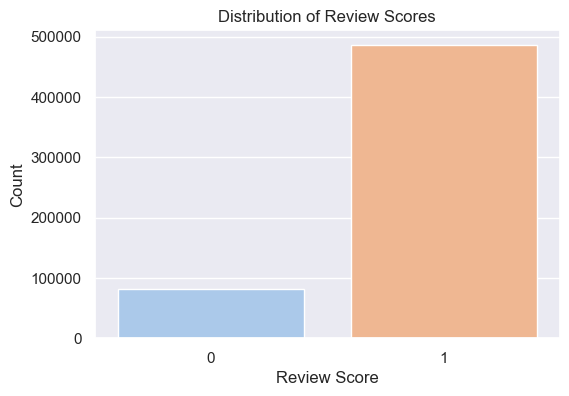

In [38]:
# Visualization 1: Distribution of Review Scores
plt.figure(figsize=(6, 4))
sns.countplot(x='review_score', data=sentiment_df)
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.show()

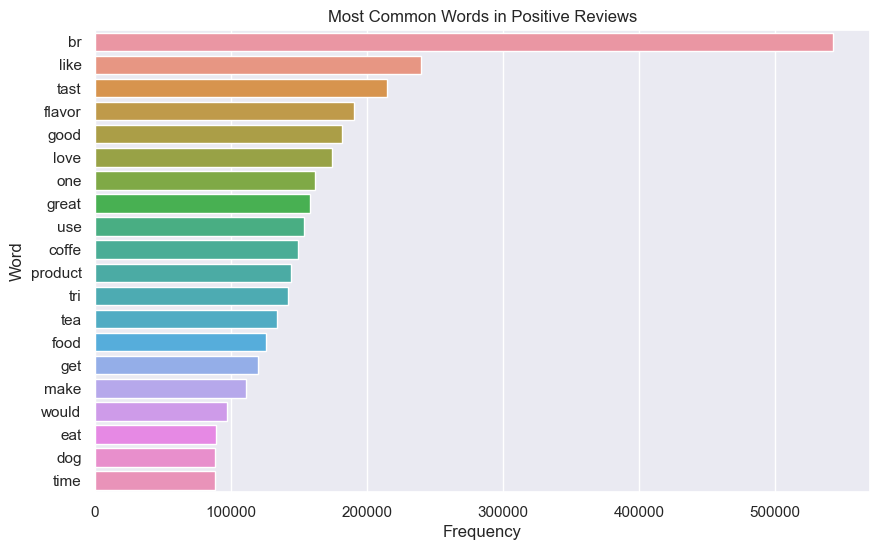

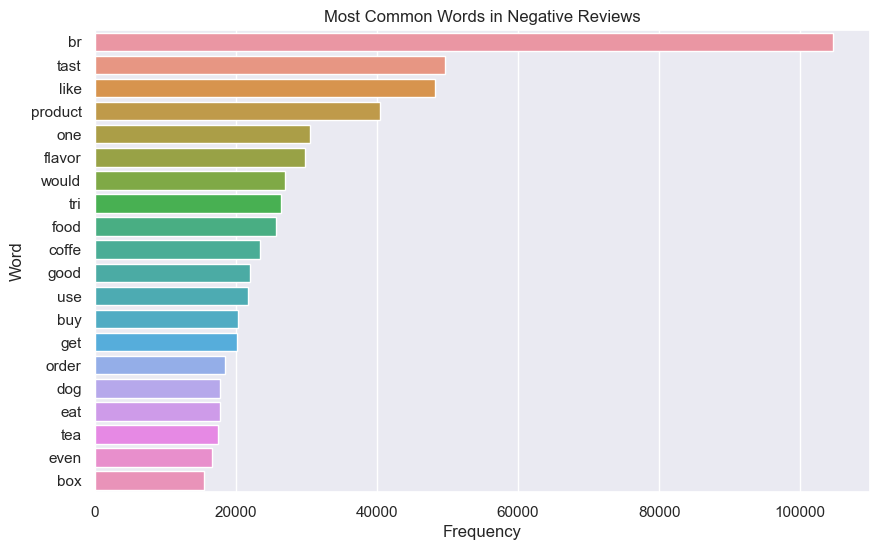

In [39]:
# Visualization 2: Word Frequency in Positive vs Negative Reviews
from collections import Counter
def plot_word_frequency(reviews, title):
    words = [word for review in reviews for word in review.split()]
    most_common_words = Counter(words).most_common(20)
    word_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Frequency', y='Word', data=word_df)
    plt.title(title)
    plt.show()

positive_reviews = sentiment_df[sentiment_df['review_score'] == 1]['review_text']
negative_reviews = sentiment_df[sentiment_df['review_score'] == 0]['review_text']
plot_word_frequency(positive_reviews, 'Most Common Words in Positive Reviews')
plot_word_frequency(negative_reviews, 'Most Common Words in Negative Reviews')

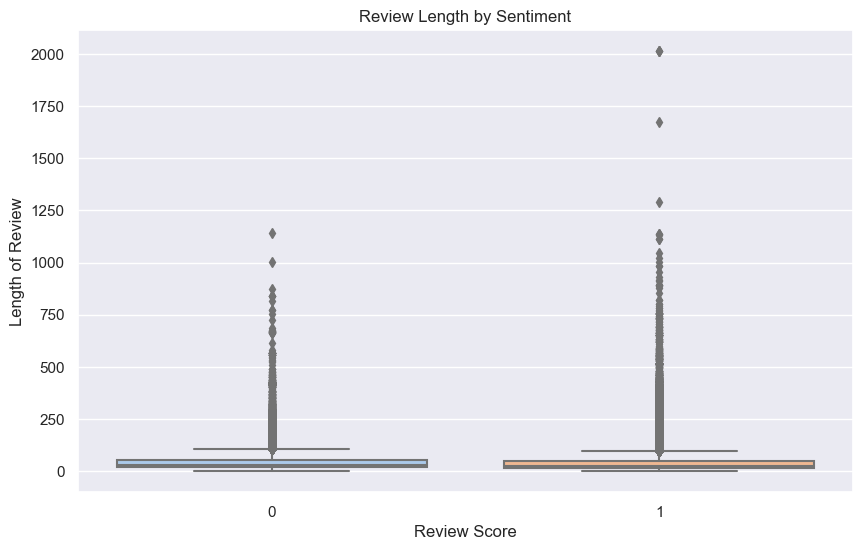

In [40]:
# Visualization 3: Length of Reviews
sentiment_df['review_length'] = sentiment_df['review_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_score', y='review_length', data=sentiment_df)
plt.title('Review Length by Sentiment')
plt.xlabel('Review Score')
plt.ylabel('Length of Review')
plt.show()

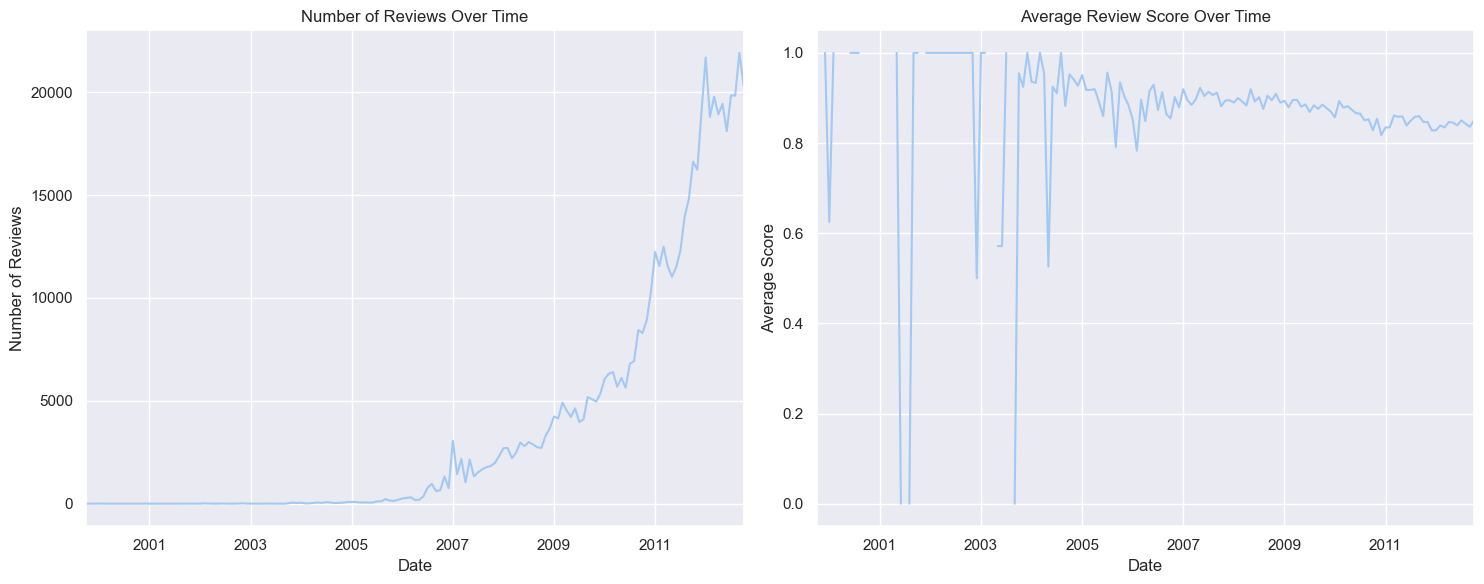

In [41]:
# Assuming sentiment_df is your DataFrame and it has a 'Time' column in UNIX timestamp format
# Convert 'Time' to a readable date format
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Time'], unit='s')

# Set the Date column as the index of the DataFrame
sentiment_df.set_index('Date', inplace=True)

# Resample data to get counts per month (or another time period like 'D' for day, 'W' for week)
monthly_review_counts = sentiment_df['review_score'].resample('M').count()
monthly_review_average = sentiment_df['review_score'].resample('M').mean()

# Plotting
plt.figure(figsize=(15, 6))

# Plot number of reviews over time
plt.subplot(1, 2, 1)
monthly_review_counts.plot()
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')

# Plot average review score over time
plt.subplot(1, 2, 2)
monthly_review_average.plot()
plt.title('Average Review Score Over Time')
plt.xlabel('Date')
plt.ylabel('Average Score')

plt.tight_layout()
plt.show()

In [42]:
X_train, X_test, y_train, y_test = train_test_split(sentiment_df['review_text'], sentiment_df['review_score'], test_size=0.2, random_state=42)

In [43]:
tokenizer_data = Tokenizer(num_words=5000)
tokenizer_data.fit_on_texts(X_train)
X_train_seq_data = tokenizer_data.texts_to_sequences(X_train)
X_test_seq_data = tokenizer_data.texts_to_sequences(X_test)

In [44]:
X_train_pad = pad_sequences(X_train_seq_data, maxlen=100)
X_test_pad = pad_sequences(X_test_seq_data, maxlen=100)

In [ ]:
#CNN

In [45]:
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=5000, output_dim=100, input_length=100))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(MaxPooling1D(5))
cnn_model.add(Flatten())
cnn_model.add(Dense(1, activation='sigmoid'))

In [46]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
cnn_model.fit(X_train_pad, y_train, epochs=2, batch_size=32, validation_split=0.1)

Epoch 1/2
12791/12791 [==============================] - 515s 40ms/step - loss: 0.2179 - accuracy: 0.9149 - val_loss: 0.1987 - val_accuracy: 0.9233
Epoch 2/2
12791/12791 [==============================] - 532s 42ms/step - loss: 0.1571 - accuracy: 0.9412 - val_loss: 0.1949 - val_accuracy: 0.9297


In [48]:
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_pad, y_test)
print(f'Test CNN Accuracy: {cnn_accuracy * 100:.2f}%')

3553/3553 [==============================] - 33s 9ms/step - loss: 0.1905 - accuracy: 0.9309
Test CNN Accuracy: 93.09%


In [49]:
y_pred_pad = cnn_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_pad, axis=1)

3553/3553 [==============================] - 39s 11ms/step


In [50]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[16181     0]
 [97510     0]]


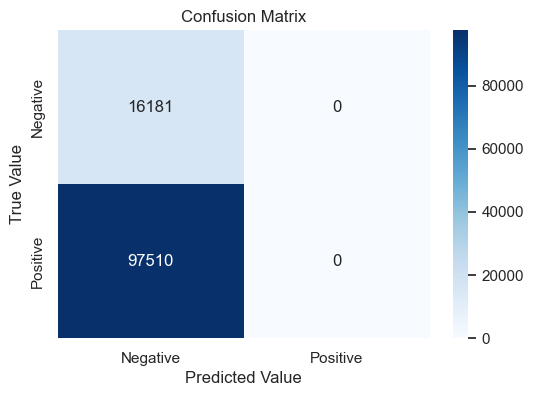

In [51]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Value")
plt.ylabel("True Value")
plt.title("Confusion Matrix")
plt.show()

In [52]:
fpr_value, tpr_value, thresholds_value = roc_curve(y_test, y_pred_pad[:, 0])
roc_auc_value = auc(fpr_value, tpr_value)
print(roc_auc_value)

0.9484841612450621


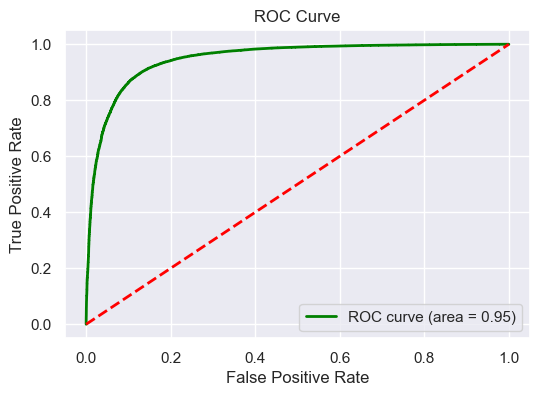

In [53]:
plt.figure(figsize=(6, 4))
plt.plot(fpr_value, tpr_value, color='green', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_value))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#RNN

In [54]:
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=5000, output_dim=100, input_length=100))
rnn_model.add(SimpleRNN(64))
rnn_model.add(Dense(1, activation='sigmoid'))

In [55]:
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
rnn_model.fit(X_train_pad, y_train, epochs=2, batch_size=32, validation_split=0.1)

Epoch 1/2
12791/12791 [==============================] - 500s 39ms/step - loss: 0.2792 - accuracy: 0.8901 - val_loss: 0.2609 - val_accuracy: 0.8956
Epoch 2/2
12791/12791 [==============================] - 491s 38ms/step - loss: 0.2665 - accuracy: 0.8951 - val_loss: 0.2708 - val_accuracy: 0.8942


In [57]:
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test_pad, y_test)
print(f'Test RNN Accuracy: {rnn_accuracy * 100:.2f}%')

3553/3553 [==============================] - 44s 12ms/step - loss: 0.2661 - accuracy: 0.8972
Test RNN Accuracy: 89.72%


In [ ]:
#LSTM

In [58]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=100, input_length=100))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1, activation='sigmoid'))

In [59]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
lstm_model.fit(X_train_pad, y_train, epochs=2, batch_size=32, validation_split=0.1)

Epoch 1/2
12791/12791 [==============================] - 1153s 90ms/step - loss: 0.2106 - accuracy: 0.9155 - val_loss: 0.1872 - val_accuracy: 0.9253
Epoch 2/2
12791/12791 [==============================] - 1105s 86ms/step - loss: 0.1688 - accuracy: 0.9331 - val_loss: 0.1772 - val_accuracy: 0.9321


In [61]:
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_pad, y_test)
print(f'Test LSTM Accuracy: {lstm_accuracy * 100:.2f}%')

3553/3553 [==============================] - 95s 27ms/step - loss: 0.1752 - accuracy: 0.9312
Test LSTM Accuracy: 93.12%


In [67]:
# RNN Model Predictions
y_pred_rnn = rnn_model.predict(X_test_pad)
y_pred_rnn = (y_pred_rnn > 0.5).astype("int32").flatten()

# LSTM Model Predictions
y_pred_lstm = lstm_model.predict(X_test_pad)
y_pred_lstm = (y_pred_lstm > 0.5).astype("int32").flatten()

3553/3553 [==============================] - 93s 26ms/step


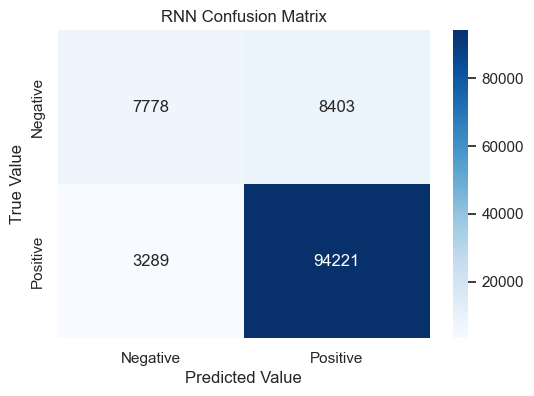

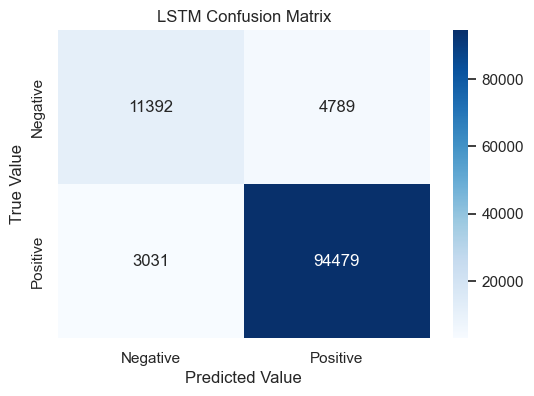

In [68]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel("Predicted Value")
    plt.ylabel("True Value")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

# Plotting confusion matrix for RNN and LSTM
plot_confusion_matrix(y_test, y_pred_rnn, 'RNN')
plot_confusion_matrix(y_test, y_pred_lstm, 'LSTM')

In [ ]:
#BERT

In [70]:
sentiment_df['Sentiment'] = [1 if score > 3 else 0 for score in sentiment_df['Score']]

In [71]:
sentiment_df['CombinedText'] = sentiment_df['Summary'] + " " + sentiment_df['review_text']

In [72]:
bert_classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [73]:
sentiment_df1 = sentiment_df.head(50)

In [74]:
for i, text in enumerate(sentiment_df1['CombinedText']):
    output = bert_classifier(text)[0]
    predicted_label = output['label']
    predicted_score = output['score']

    print(f"Data {i + 1}:")
    print(f"Text: {text}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Predicted Score: {predicted_score:.4f}")
    print("=" * 50)

Data 1:
Text: good qualiti dog food bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better
Predicted Label: NEGATIVE
Predicted Score: 0.9624
Data 2:
Text: advertis product arriv label jumbo salt peanutsth peanut actual small size unsalt sure error vendor intend repres product jumbo
Predicted Label: NEGATIVE
Predicted Score: 0.9987
Data 3:
Text: delight say confect around centuri light pillowi citrus gelatin nut case filbert cut tini squar liber coat powder sugar tini mouth heaven chewi flavor high recommend yummi treat familiar stori cs lewi lion witch wardrob treat seduc edmund sell brother sister witch
Predicted Label: POSITIVE
Predicted Score: 0.9699
Data 4:
Text: cough medicin look secret ingredi robitussin believ found got addit root beer extract order good made cherri soda flavor medicin
Predicted Label: POSITIVE
Predicted Score: 0.9686
Data 5:
Text: great taffi great taffi great price wi